In [1]:
import tensorflow as tf
import pandas as pd

## Load the titanic dataset

In [3]:
# Load dataset.
train_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
eval_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
train_y = train_df.pop('survived')
eval_y = eval_df.pop('survived')

## Feature Engineering for the Model

### Base Feature Columns

In [5]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocab = train_df[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature_name,
        vocabulary_list=vocab
    ))
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(key=feature_name, dtype=tf.float32))

In [11]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):

    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((data_df.to_dict('list'), label_df))
        if shuffle:
            dataset = dataset.shuffle(1000)
        dataset = dataset.batch(batch_size).repeat(num_epochs)
        return dataset
    
    return input_fn

train_input_fn = make_input_fn(train_df, train_y, num_epochs=10, shuffle=True)
eval_input_fn = make_input_fn(eval_df, eval_y, num_epochs=1, shuffle=False)

In [16]:
linear_estimator = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=2
)
linear_estimator.train(train_input_fn)
results = linear_estimator.evaluate(eval_input_fn)
IPython.display.clear_output()
results

{'accuracy': 0.7386364,
 'accuracy_baseline': 0.625,
 'auc': 0.8353842,
 'auc_precision_recall': 0.79169124,
 'average_loss': 0.48395082,
 'label/mean': 0.375,
 'loss': 0.4781909,
 'precision': 0.6442308,
 'prediction/mean': 0.4234023,
 'recall': 0.67676765,
 'global_step': 200}

### Derived Feature Columns

Now you reached an accuracy of 75%. Using each base feature column separately may not be enough to explain the data. For example, the correlation between gender and the label may be different for different gender. Therefore, if you only learn a single model weight for `gender="Male"` and `gender="Female"`, you won't capture every age-gender combination (e.g. distinguishing between `gender="Male"` AND `age="30"` AND `gender="Male"` AND `age="40"`).

In [17]:
# Add crossed feature columns to the model
# You can also bucketize `age` columnj before the cross column.
age_x_gender = tf.feature_column.crossed_column(keys=['age', 'sex'], hash_bucket_size=100)

In [19]:
derived_feature_columns = [age_x_gender]
linear_estimator = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_estimator.train(train_input_fn)
results = linear_estimator.evaluate(eval_input_fn)
IPython.display.clear_output()
results

{'accuracy': 0.77272725,
 'accuracy_baseline': 0.625,
 'auc': 0.83914906,
 'auc_precision_recall': 0.7712903,
 'average_loss': 0.49568614,
 'label/mean': 0.375,
 'loss': 0.4854032,
 'precision': 0.73493975,
 'prediction/mean': 0.30859646,
 'recall': 0.61616164,
 'global_step': 200}

In [23]:
pred_dicts = list(linear_estimator.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphurlbpbf/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


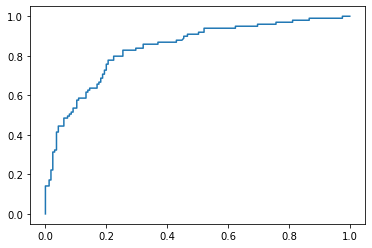

In [27]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(eval_y, probs)
plt.plot(fpr, tpr)